## **MMCCI Melanoma Integration and Analysis Example**

In this example, we have melanoma samples from three different technologies - Visium, CosMX and Xenium.
Each sample has been run through stLearn CCI and the outputs are saved as `.h5ad` files.

We will integrate the samples together, and then run analysis on the integrated results.

### **Integration**

These CCI results will be integrated together in this notebook with the following steps:
1. Load the stLearn outputs and convert to be used with MMCCI
2. Integrate by technology (Visium, CosMX, Xenium)
3. Integrate within each patient (4 different patients)

\
Note: This notebook took <10 mins to run and used <16GB of memory

In [1]:
import multimodal_cci as mmcci

2024-07-12 12:15:53.475279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-12 12:15:53.586872: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 12:15:53.590236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-12 12:15:53.590255: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc

#### 1. Load stLearn outputs

This data is available on the GitHub repo and includes the `adata.uns['per_lr_cci_cell_type]` for each sample, as well as the number of spots for each sample

In [2]:
import pickle

with open('../data/melanoma_data.pkl', 'rb') as f:
    melanoma_data = pickle.load(f)

In [3]:
# These colours will be used for plotting later

from matplotlib import pyplot as plt

colors = {
    'Endothelial': plt.colormaps.get_cmap('tab20').colors[0],
    'Fibroblast': plt.colormaps.get_cmap('tab20').colors[1],
    'KC Differentiating': plt.colormaps.get_cmap('tab20').colors[2],
    'KC Cycling': plt.colormaps.get_cmap('tab20').colors[3],
    'KC Basal': plt.colormaps.get_cmap('tab20').colors[4],
    'KC Other': plt.colormaps.get_cmap('tab20').colors[5],
    'NK + T': plt.colormaps.get_cmap('tab20').colors[6],
    'B + PDC': plt.colormaps.get_cmap('tab20').colors[7],
    'Melanocyte': plt.colormaps.get_cmap('tab20').colors[8],
    'Myeloid': plt.colormaps.get_cmap('tab20').colors[9],
    'Pilosebaceous': plt.colormaps.get_cmap('tab20').colors[10],
    'NotDet': plt.colormaps.get_cmap('tab20').colors[11],
}

Some of the celltype names are slightly different between technologies, so we can fix that with this function

In [4]:
cell_type_replacements = {
    'KC.Basal': 'KC Basal',
    'KC_Basal': 'KC Basal',
    'KC.Cycling': 'KC Cycling',
    'KC_Cyc': 'KC Cycling',
    'KC_Diff': 'KC Differentiating',
    'KC_Other': 'KC Other',
    'NK.T': 'NK + T',
    'B.PDC': 'B + PDC',
    'B...PDC': 'B + PDC',
}

visium_cci = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['visium_cci']]
cosmx_cci = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['cosmx_cci']]
xenium_cci = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['xenium_cci']]

visium_pvals = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['visium_pvals']]
cosmx_pvals = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['cosmx_pvals']]
xenium_pvals = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['xenium_pvals']]

#### 2. Integrate by technology

This step first normalises the samples based on the number of spots

In [5]:
visium_normalised = mmcci.it.normalise_within_tech(visium_cci, melanoma_data['visium_sizes'])
xenium_normalised = mmcci.it.normalise_within_tech(xenium_cci, melanoma_data['xenium_sizes'])
cosmx_normalised = mmcci.it.normalise_within_tech(cosmx_cci, melanoma_data['cosmx_sizes'])

Next, we integrate all the samples within each technology and plot a network plot for each one

Integrating p values: 100%|██████████| 1425/1425 [01:00<00:00, 23.69it/s]


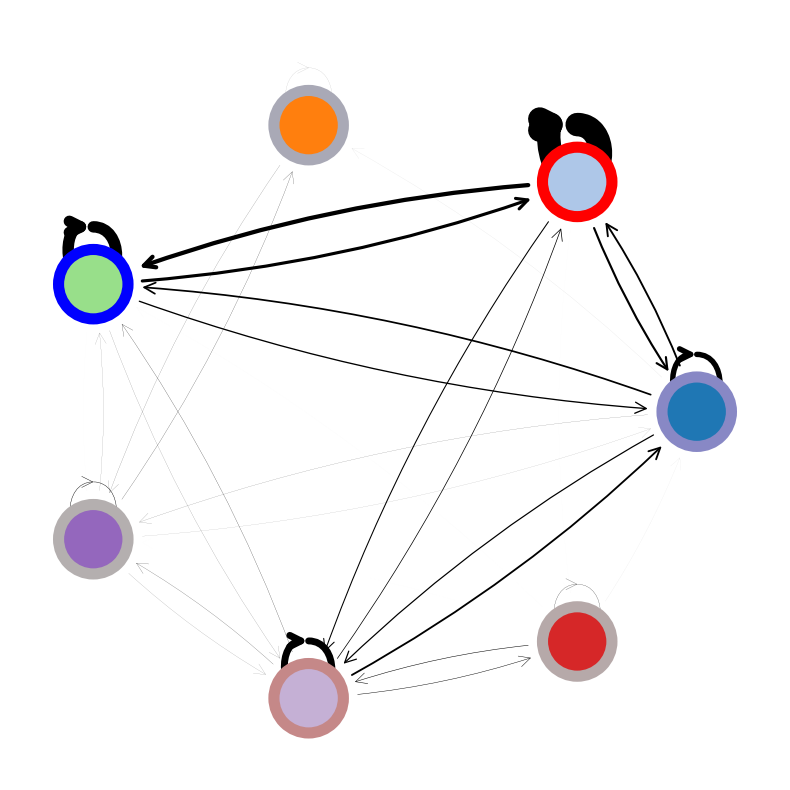

Integrating p values: 100%|██████████| 13/13 [00:00<00:00, 21.87it/s]


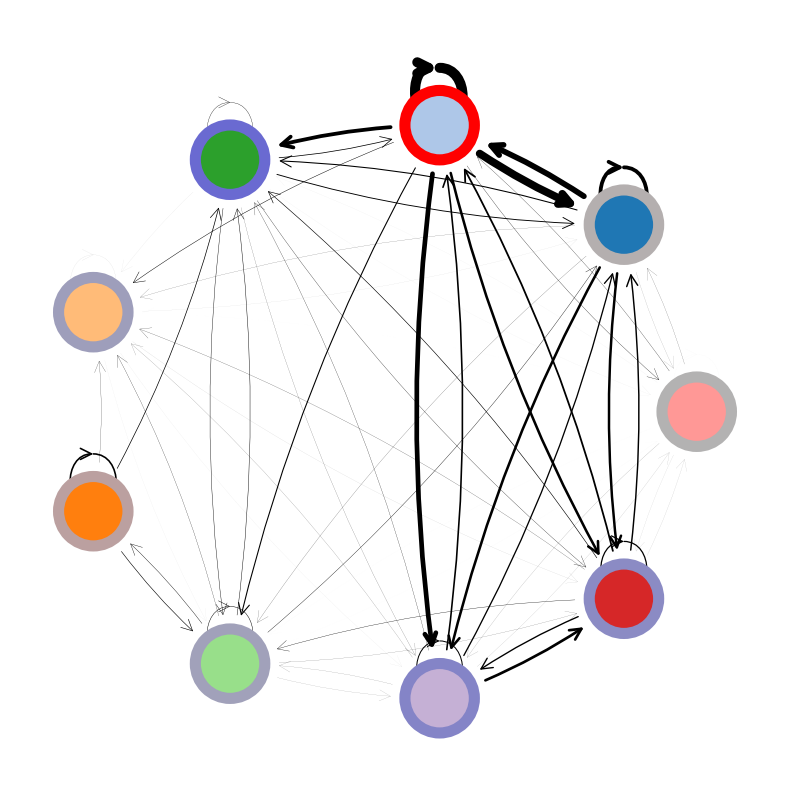

Integrating p values: 100%|██████████| 517/517 [00:30<00:00, 16.83it/s]


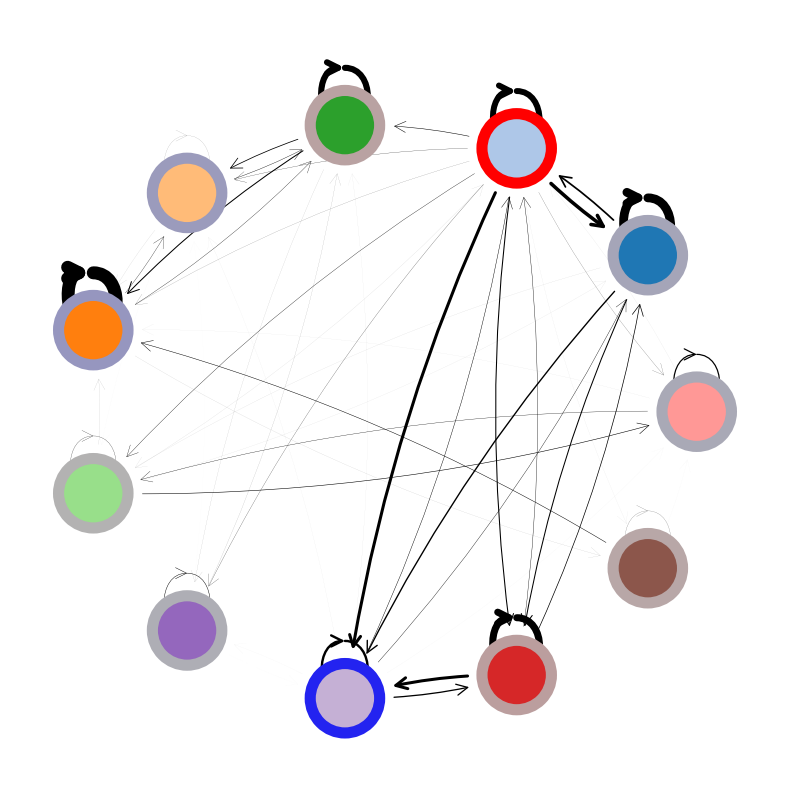

In [6]:
integrated_tech = {}
overall = {}

for tech, samples in zip(['vis', 'xen', 'cos'], [visium_normalised, xenium_normalised, cosmx_normalised]):
    integrated_tech[tech] = mmcci.it.integrate_samples(samples, method=">=50%")
    
    if tech == 'vis':
        p_vals = mmcci.it.integrate_p_vals(visium_pvals)
    elif tech == 'xen':
        p_vals = mmcci.it.integrate_p_vals(xenium_pvals)
    else:
        p_vals = mmcci.it.integrate_p_vals(cosmx_pvals)
        
    integrated = mmcci.it.remove_insignificant(integrated_tech[tech], p_vals)
    overall[tech] = mmcci.it.calculate_overall_interactions(integrated)
    mmcci.plt.network_plot(overall[tech], show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors)

Finally, we can integrate each of these together to get a complete integrated network

Integrating p values: 100%|██████████| 1540/1540 [01:16<00:00, 20.04it/s]


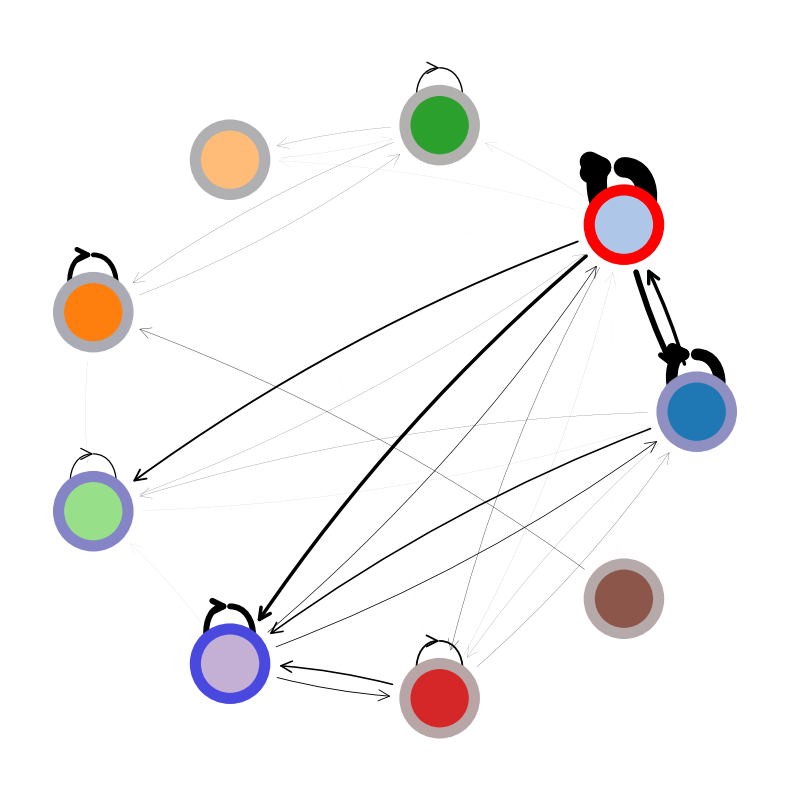

In [7]:
normalised = mmcci.it.normalise_between_tech(
    [integrated_tech['vis'], integrated_tech['xen'], integrated_tech['cos']]
    )

integrated = mmcci.it.integrate_samples(normalised)
p_vals = mmcci.it.integrate_p_vals(visium_pvals + xenium_pvals + cosmx_pvals)
integrated = mmcci.it.remove_insignificant(integrated, p_vals)
overall = mmcci.it.calculate_overall_interactions(integrated)

mmcci.plt.network_plot(overall, show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors)

#### 3. Integrate by patient

We use the same normalised CCI results as before but integrate by patient now

In [8]:
# Define the samples that each patient has

p6747 = {
    'vis': [visium_normalised[3]],
    'cos': [cosmx_normalised[0]],
}

p21031 = {
    'vis': [visium_normalised[1]],
    'cos': [cosmx_normalised[1], cosmx_normalised[2]],
}

p48974 = {
    'vis': [visium_normalised[0]],
    'cos': [cosmx_normalised[3], cosmx_normalised[4], cosmx_normalised[5]],
}

p66487 = {
    'vis': [visium_normalised[2]],
    'cos': [cosmx_normalised[6], cosmx_normalised[7]],
}

patients = {"6747": p6747, "21031": p21031, "48974": p48974, "66487": p66487}

P6747_pvals = {
    'vis': [visium_pvals[3]],
    'cos': [cosmx_pvals[0]],
}

P21031_pvals = {
    'vis': [visium_pvals[1]],
    'cos': [cosmx_pvals[1], cosmx_pvals[2]],
}

P48974_pvals = {
    'vis': [visium_pvals[0]],
    'cos': [cosmx_pvals[3], cosmx_pvals[4], cosmx_pvals[5]],
}

P66487_pvals = {
    'vis': [visium_pvals[2]],
    'cos': [cosmx_pvals[6], cosmx_pvals[7]],
}

mel_patients_pvals = {"6747": P6747_pvals, "21031": P21031_pvals, "48974": P48974_pvals, "66487": P66487_pvals}

Integrating p values: 100%|██████████| 645/645 [00:29<00:00, 21.55it/s]


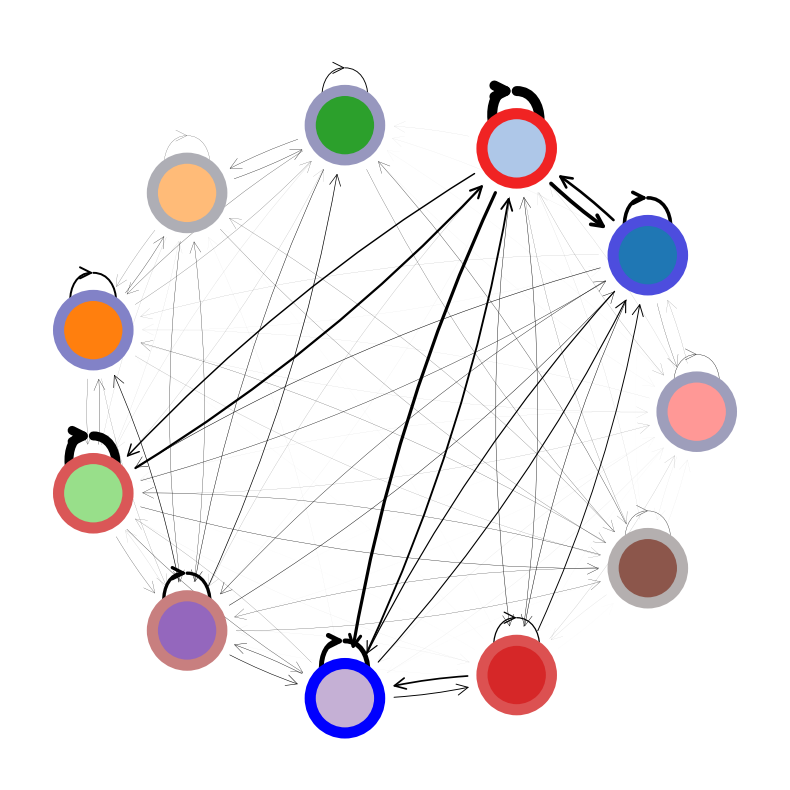

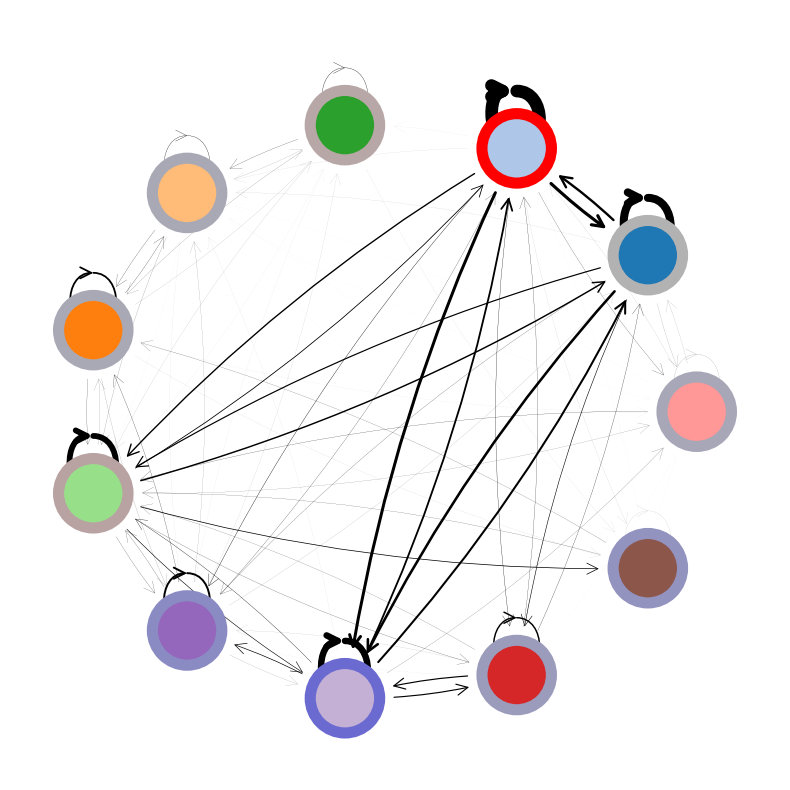

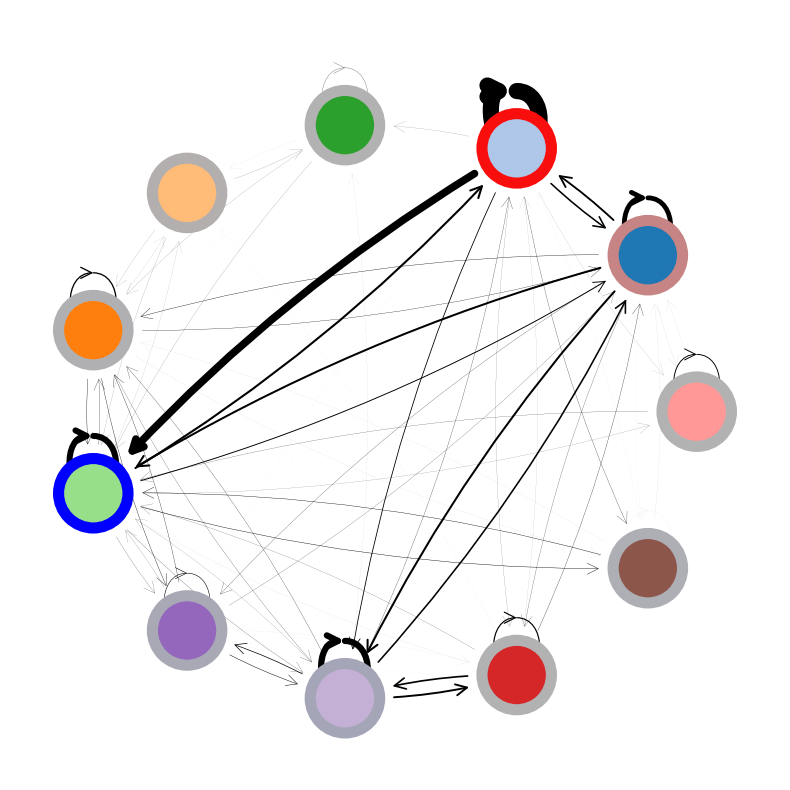

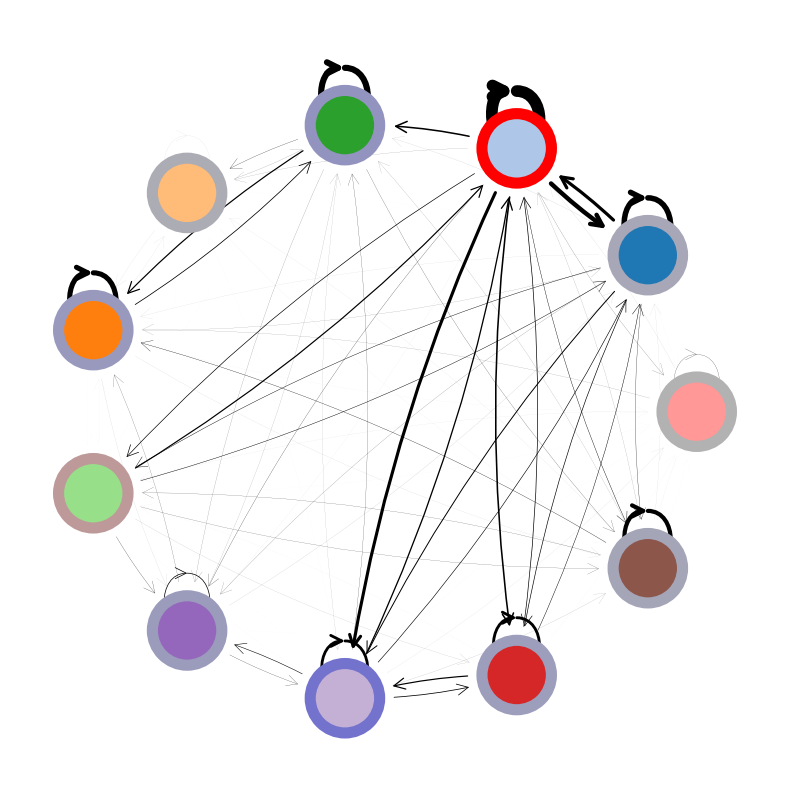

In [9]:
patient_integrated = {}

for patient, samples in patients.items():
    for tech in patients[patient].keys():
        if len(samples[tech]) >= 2:
            samples[tech] = mmcci.it.integrate_samples(samples[tech])
        else:
            samples[tech] = samples[tech][0]
    normalised = mmcci.it.normalise_between_tech([samples['vis'], samples['cos']])
    integrated = mmcci.it.integrate_samples(normalised, method=">=50%")
    patient_integrated[patient] = integrated
    
patient_pvals = {}
for patient, samples in mel_patients_pvals.items():
    sample_list = []
    for tech in mel_patients_pvals[patient].keys():
        sample_list.extend(samples[tech])
    patient_pvals[patient] = mmcci.it.integrate_p_vals(sample_list)
    
mel_patient_integrated_filtered = {}

for patient in patient_integrated.keys():
    mel_patient_integrated_filtered[patient] = mmcci.it.remove_insignificant(patient_integrated[patient], patient_pvals[patient])
    overall = mmcci.it.calculate_overall_interactions(mel_patient_integrated_filtered[patient])
    mmcci.plt.network_plot(overall, show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors)


We can then integrate all the patients together as well

Integrating p values: 100%|██████████| 1540/1540 [01:14<00:00, 20.71it/s]


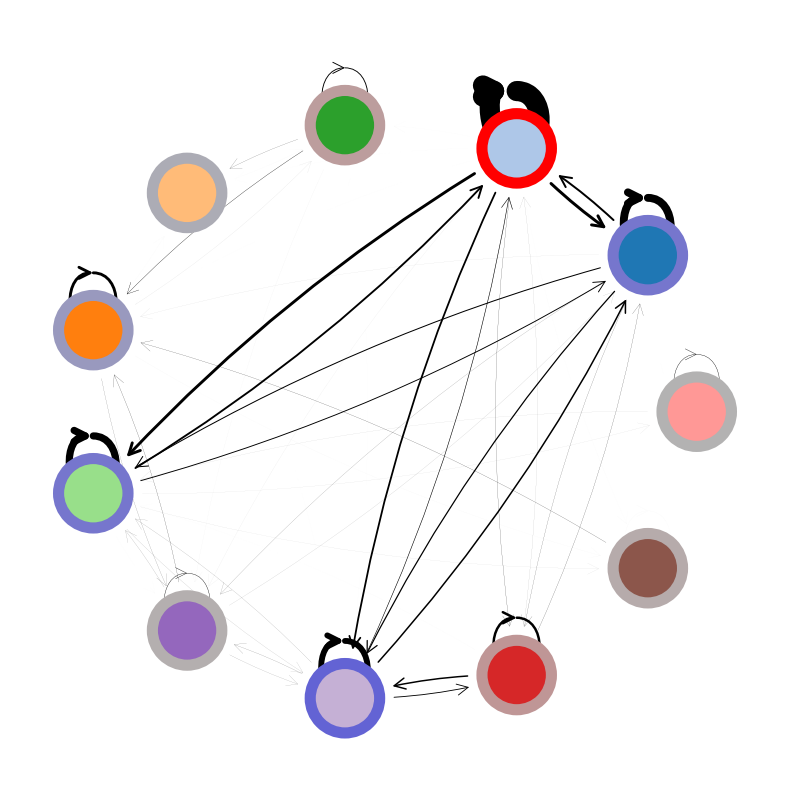

In [10]:
normalised = mmcci.it.normalise_between_tech(
    [patient_integrated['6747'], patient_integrated['21031'], patient_integrated['48974'], patient_integrated['66487']]
    )

integrated = mmcci.it.integrate_samples(normalised)
integrated_pvals = mmcci.it.integrate_p_vals(
    mel_patients_pvals['6747']['vis'] + mel_patients_pvals['6747']['cos'] +
    mel_patients_pvals['21031']['vis'] + mel_patients_pvals['21031']['cos'] +
    mel_patients_pvals['48974']['vis'] + mel_patients_pvals['48974']['cos'] +
    mel_patients_pvals['66487']['vis'] + mel_patients_pvals['66487']['cos']
    )

integrated = mmcci.it.remove_insignificant(integrated, integrated_pvals)
overall = mmcci.it.calculate_overall_interactions(integrated)

mmcci.plt.network_plot(overall, show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors)

## **Analysis**

Here we will have a look deeper into some specific interactions relevant to the disease

#### Get LR pairs and pathways from fibroblasts to endothelial cells for each patient

Patient: 6747


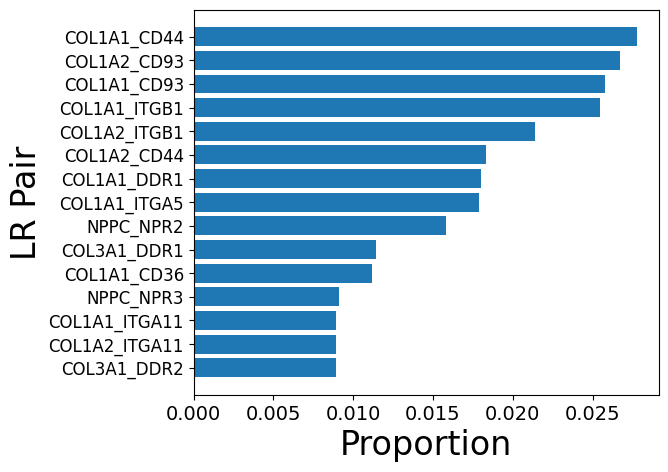

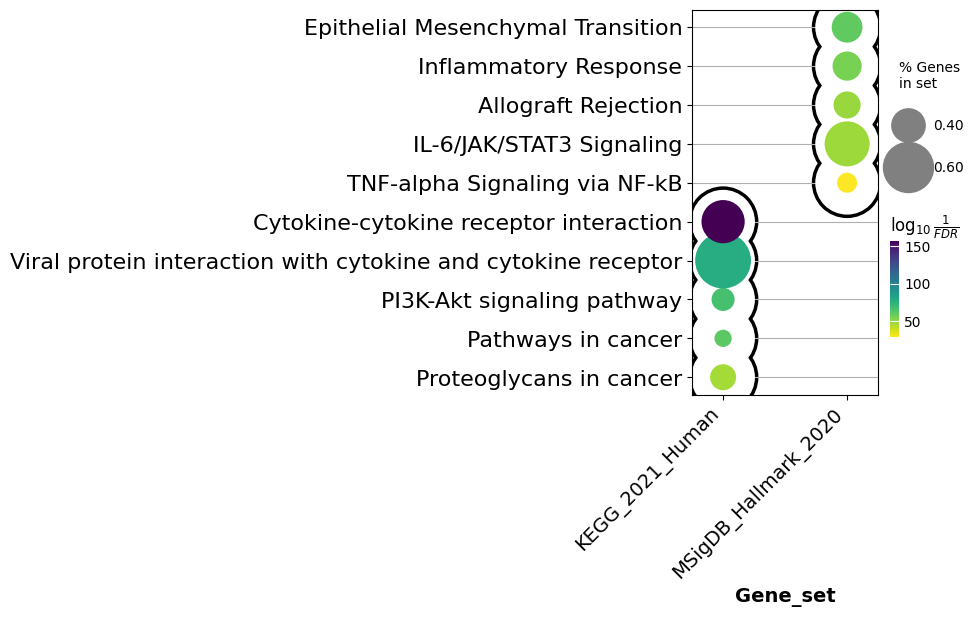

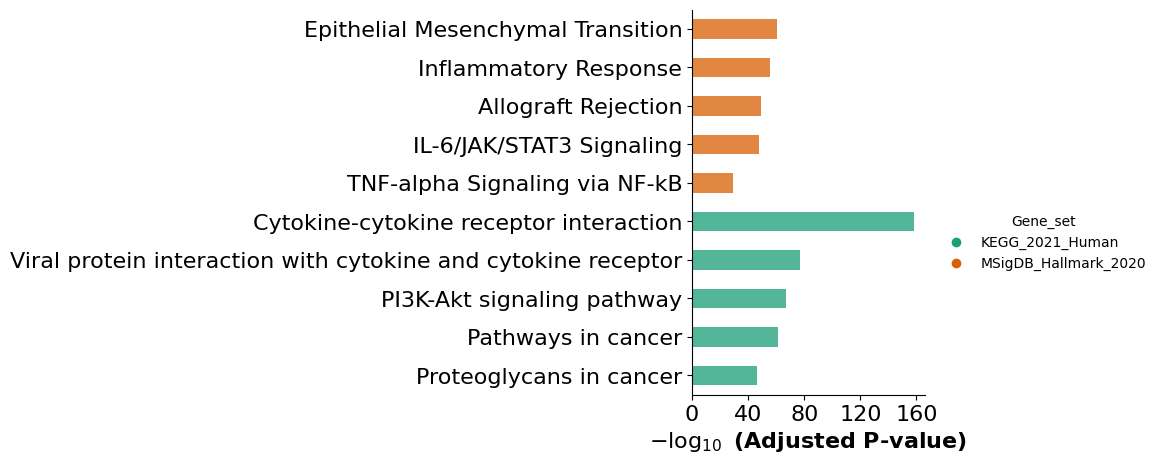

Patient: 21031


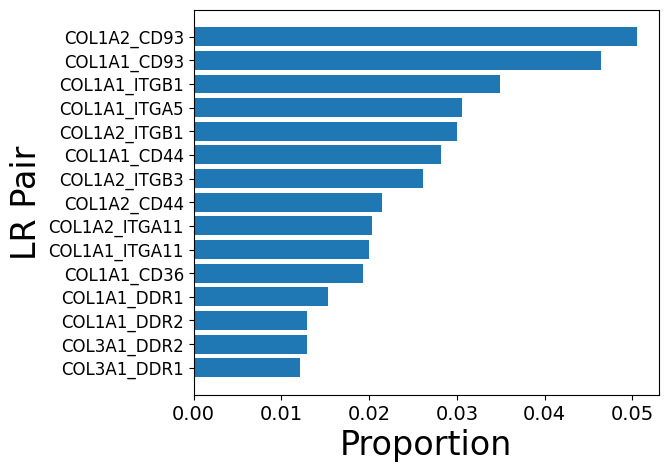

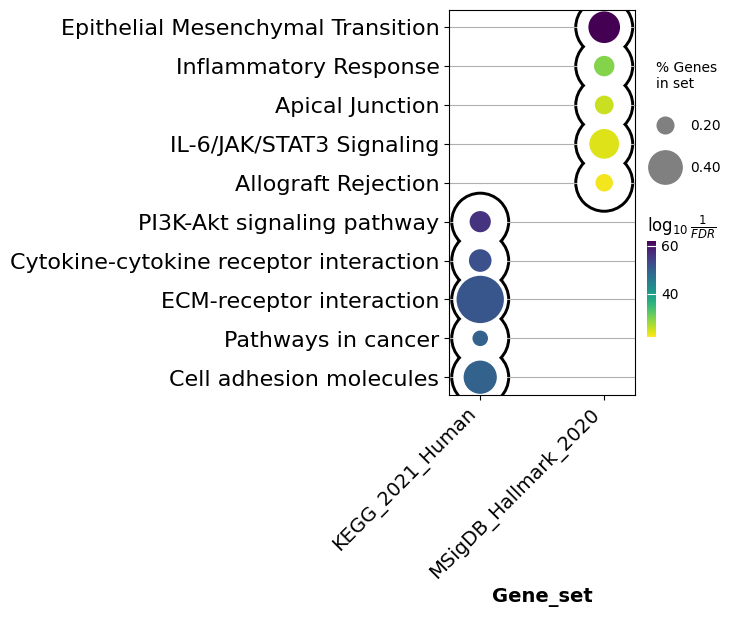

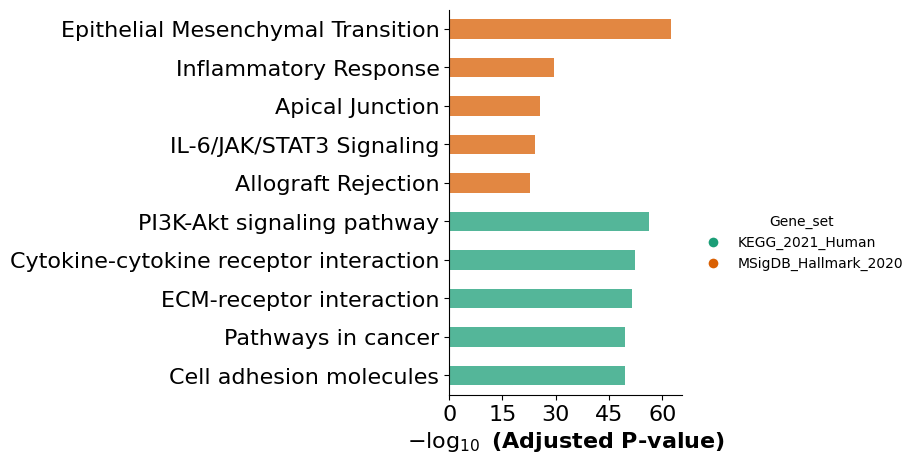

Patient: 48974


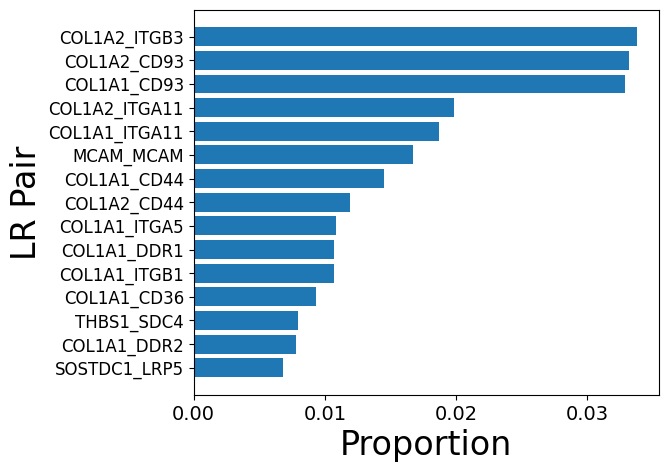

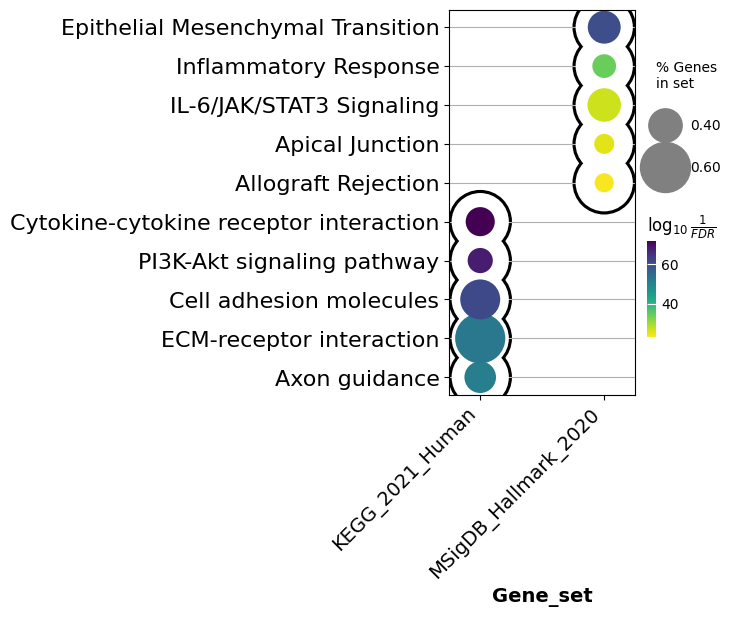

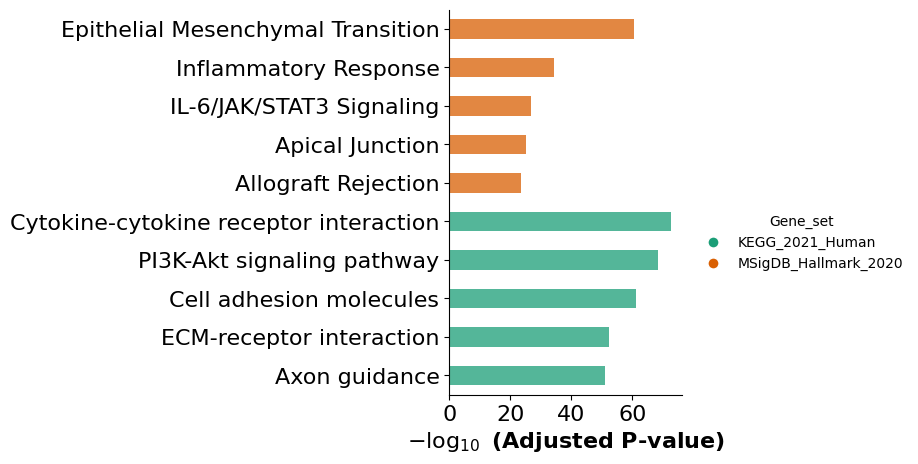

Patient: 66487


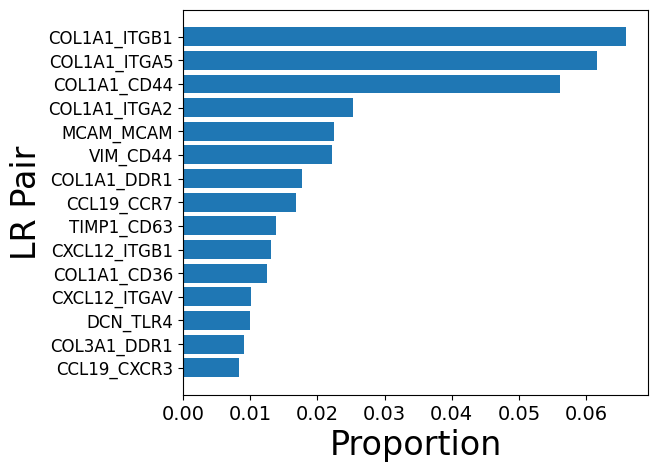

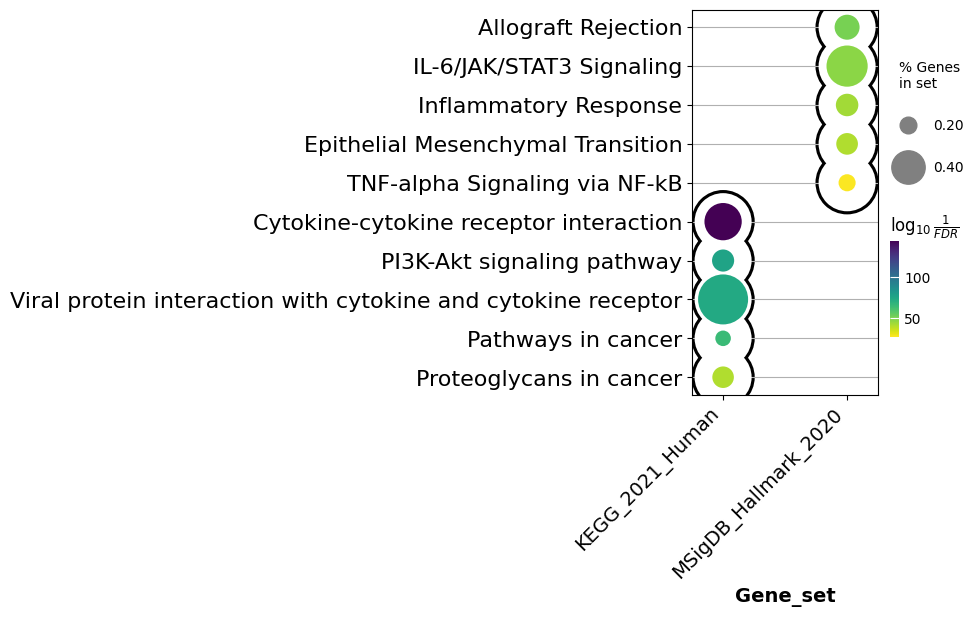

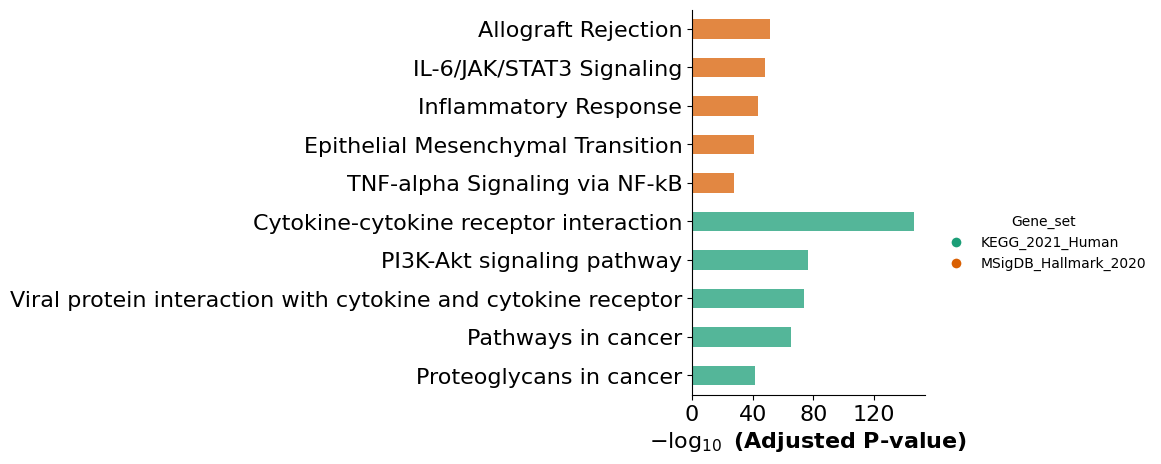

In [11]:
for name, patient in patient_integrated.items():
    print(f"Patient: {name}")
    mmcci.plt.lrs_per_celltype(patient, "Fibroblast", "Endothelial")
    mmcci.an.run_gsea(patient, mmcci.an.get_lrs_per_celltype(patient, "Fibroblast", "Endothelial"))
    plt.show()